# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'figs','TTA')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict
import random

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

In [5]:
import uncertainty.metrics as metrics
from uncertainty import TestAugmentation as TTA

# Analysis

## Definitions

In [6]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA + '_TTA'

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
WEIGTH_FILE = 0
TRANSFORMS =[TTA.F.hflip,
            TTA.Scale(1.04),
            TTA.Scale(1.1),
            TTA.Rotate(15),
            TTA.Rotate(-15),
            TTA.Multiply(0.8),
            TTA.Multiply(1.2),
            TTA.Add(0.1),
            TTA.Add(-0.1),
            TTA.FiveCrop(32,4)]

## Upload Models

In [8]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files

def upload_weights(file, weights_path):
    files = weights_files(weights_path)

    if isinstance(file,int):
        weights = files[file]
        weights = os.path.join(weights_path,weights)
    elif file == 'random':
        weights = random.choice(files)
        weights = os.path.join(weights_path,weights)
    elif file == 'max':
        return upload_weights(0, weights_path)
    elif isinstance(file,str):
        if file in files:
            weights = os.path.join(weights_path,file)
        elif file+'.pt' in files:
            weights = os.path.join(weights_path,file+'.pt')
        else: raise Exception("No file named ", file)
    state_dict = torch.load(weights)
    return state_dict


In [9]:
model = model_class(num_classes = data.n_classes,softmax = True).to(dev)
model.eval()
model.load_state_dict(upload_weights(WEIGTH_FILE, weights_path))
print(f'Acurácia (modelo determinístico): {TE.model_acc(model,data.test_dataloader)}')

Acurácia (modelo determinístico): 72.49


In [10]:
model_tta = TTA.TTA(model, as_ensemble= True, transforms = TRANSFORMS).to(dev)
print(f'Acurácia (com MCD): {TE.model_acc(model_tta,data.test_dataloader, set_eval = False)}')

Acurácia (com MCD): 73.18


## Plots

### Deterministic Inference

#### Risk x Coverage

In [11]:
model_tta_det = TTA.TTA(model, as_ensemble= False, transforms = TRANSFORMS).to(dev)

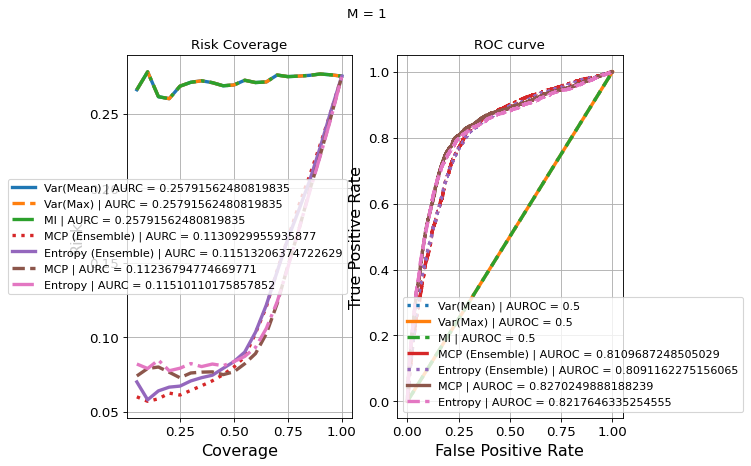

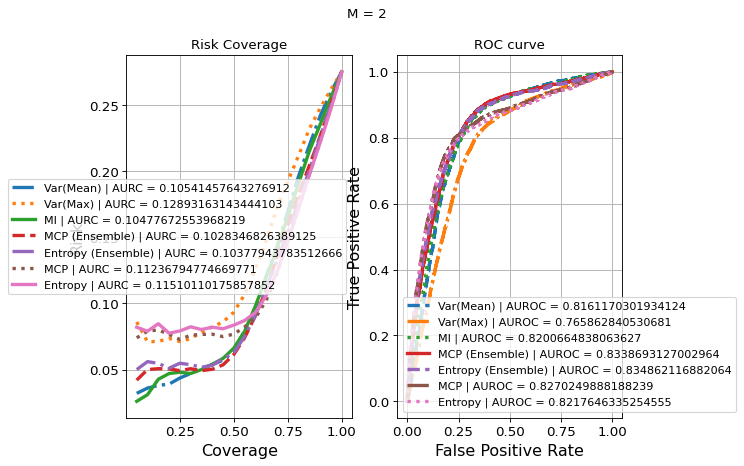

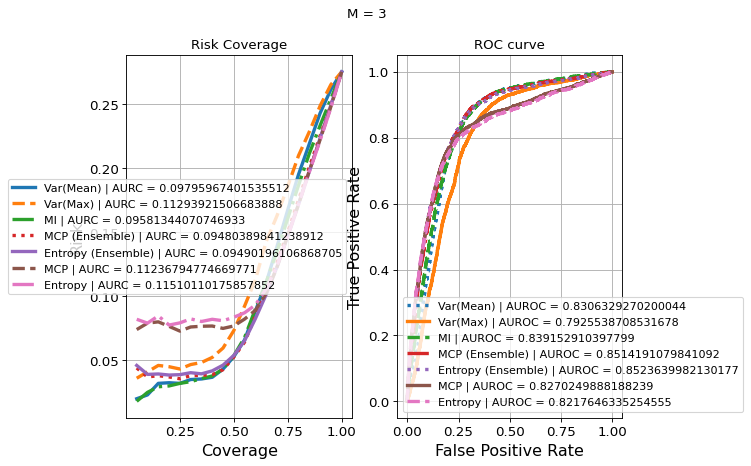

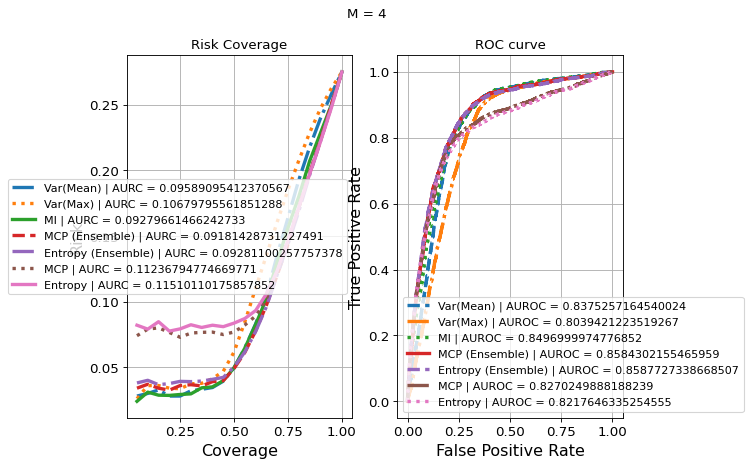

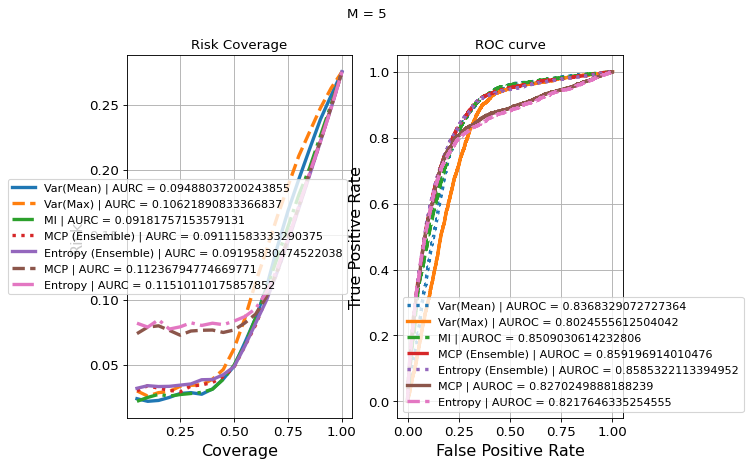

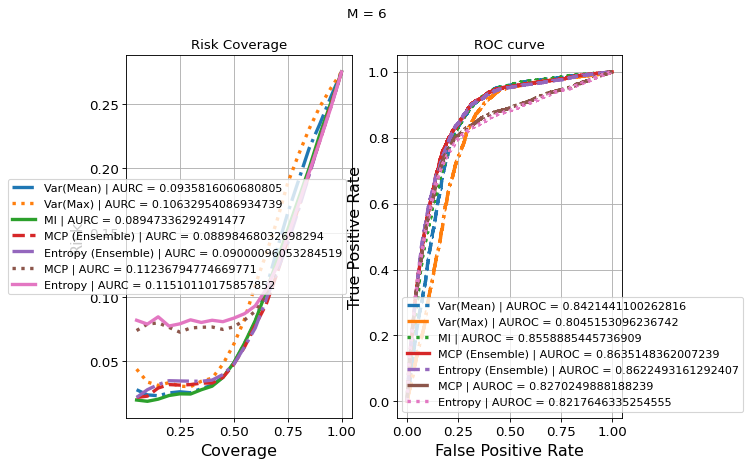

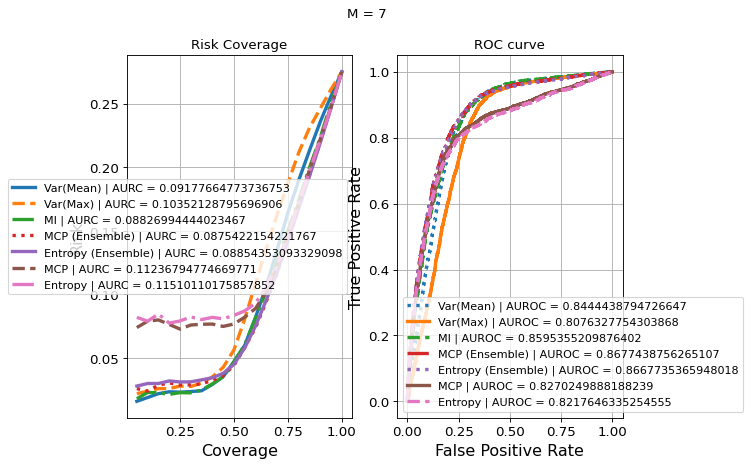

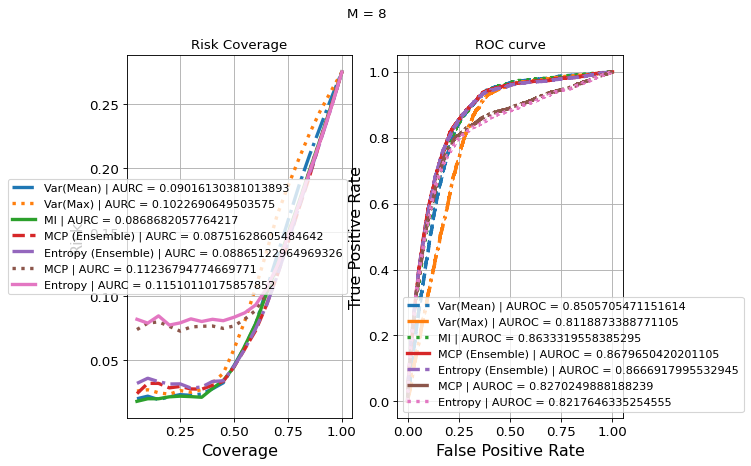

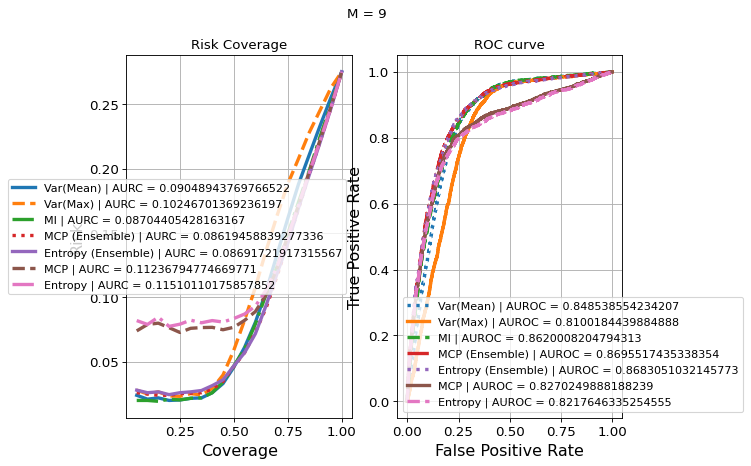

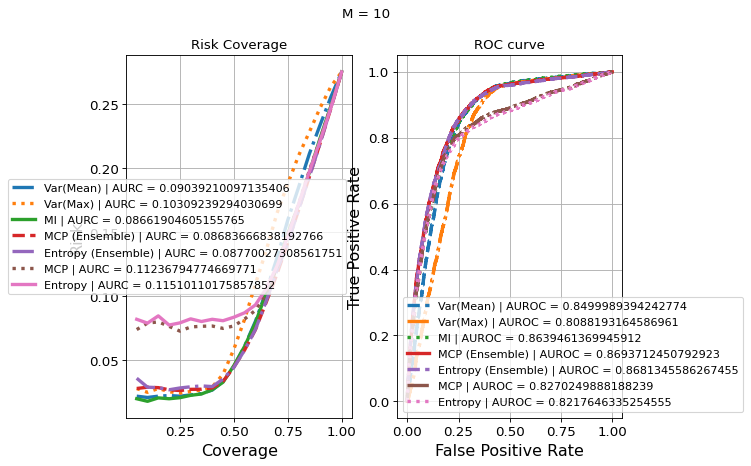

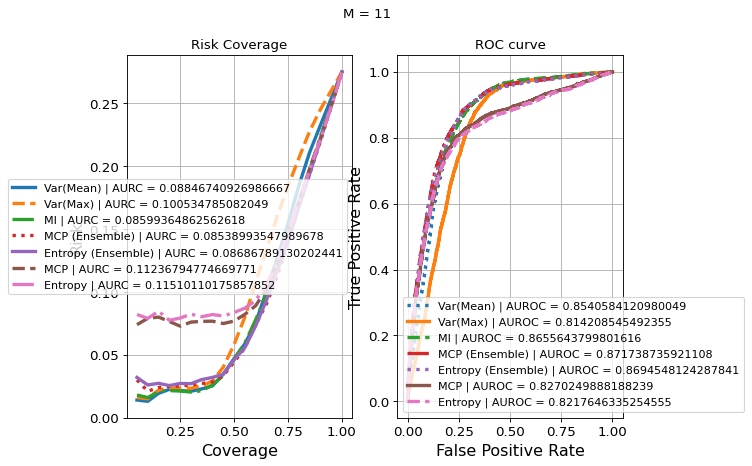

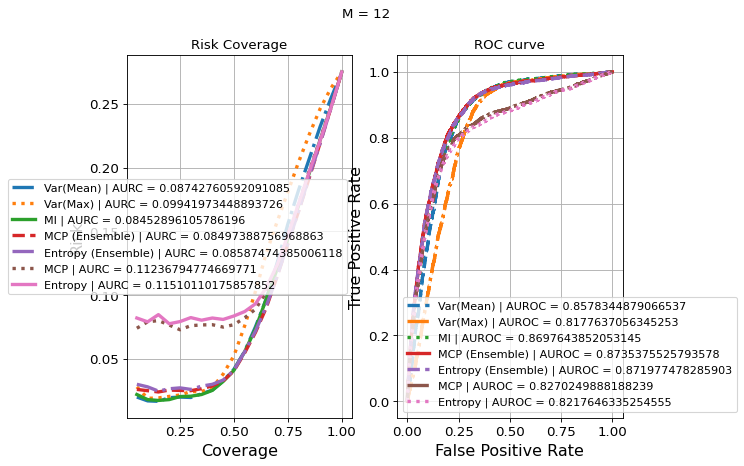

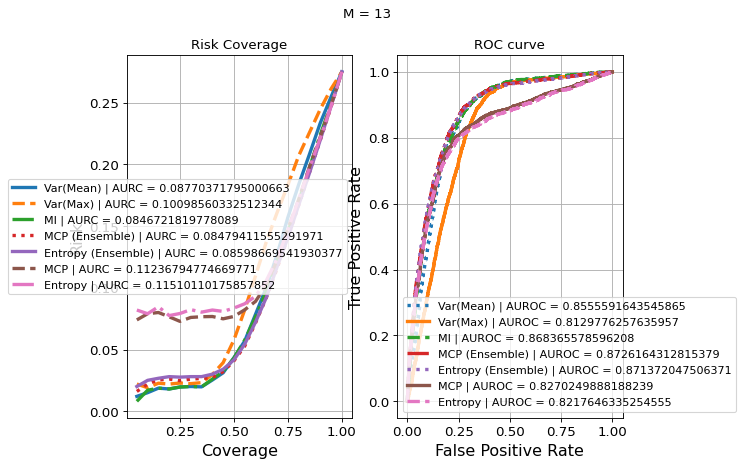

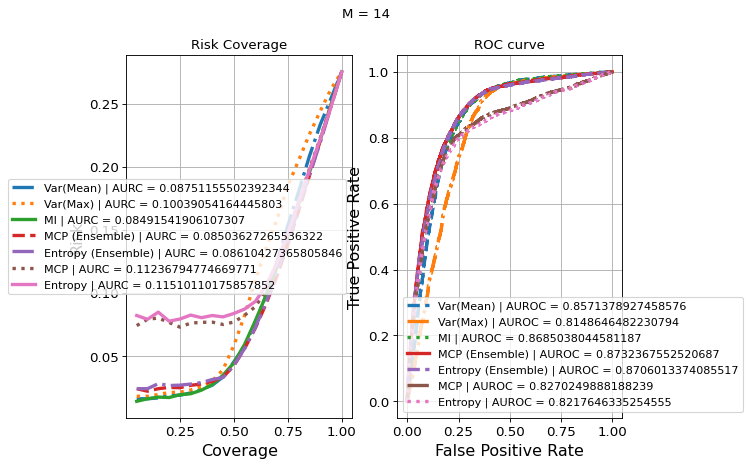

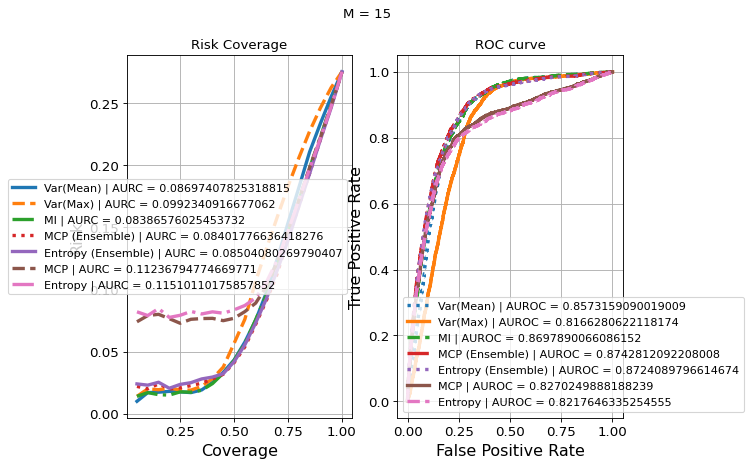

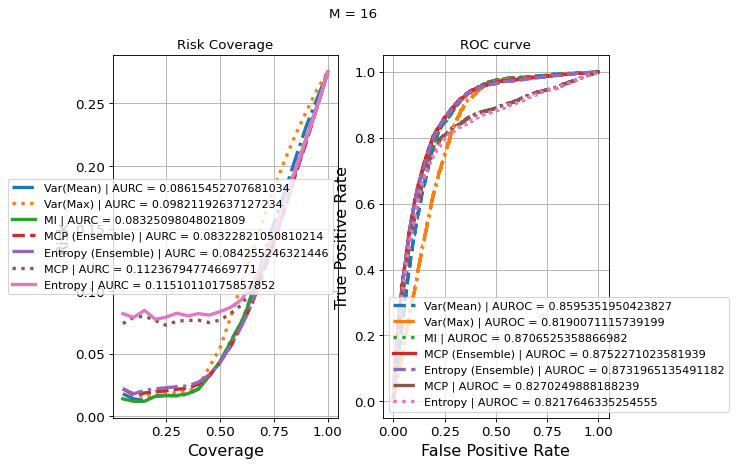

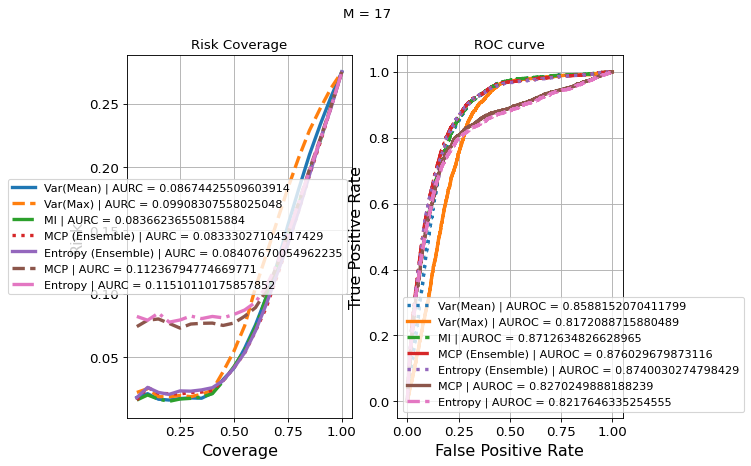

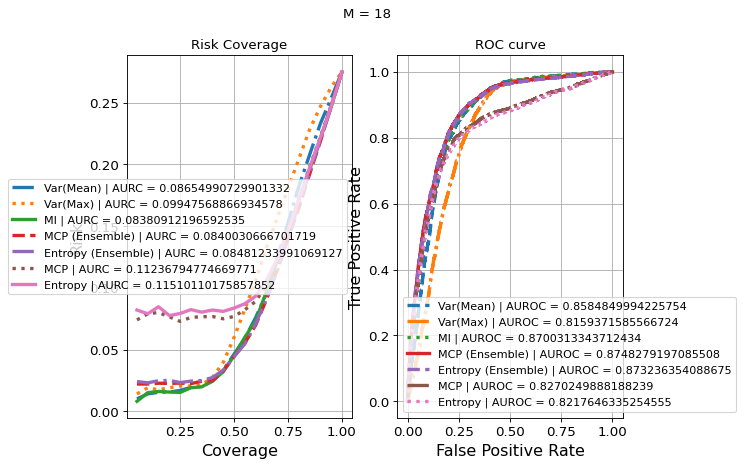

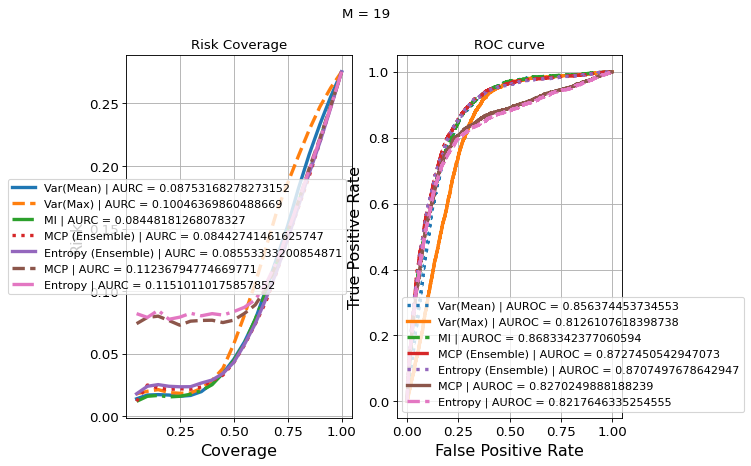

In [12]:
RC = metrics.selective_metrics(model_tta_det,None)
RC.get_uncs(data.test_dataloader)
RC.plot_ROC_and_RC(aurc = True)
plt.show()

### Ensemble (average)

#### Risk x Coverage

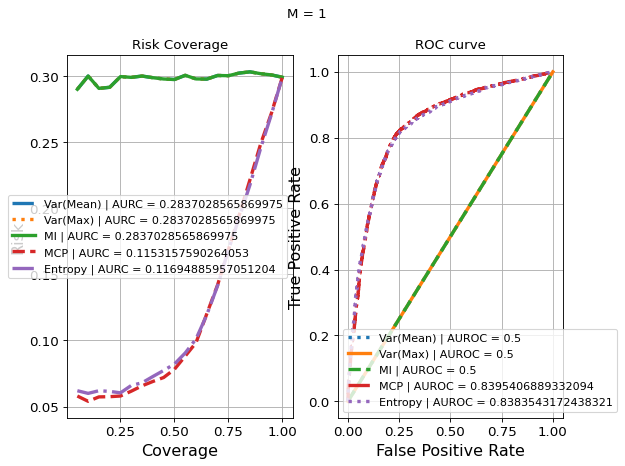

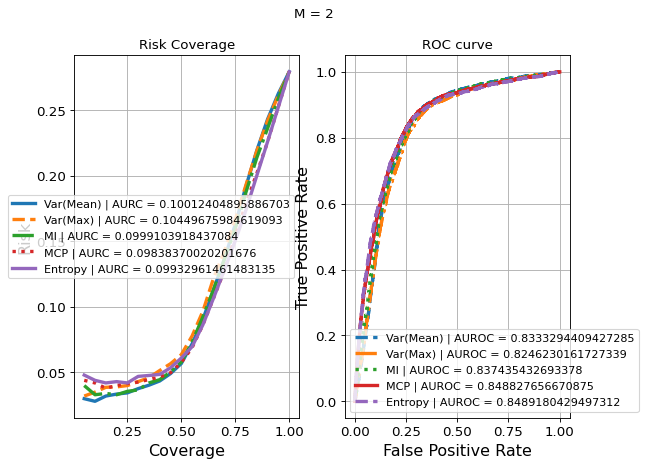

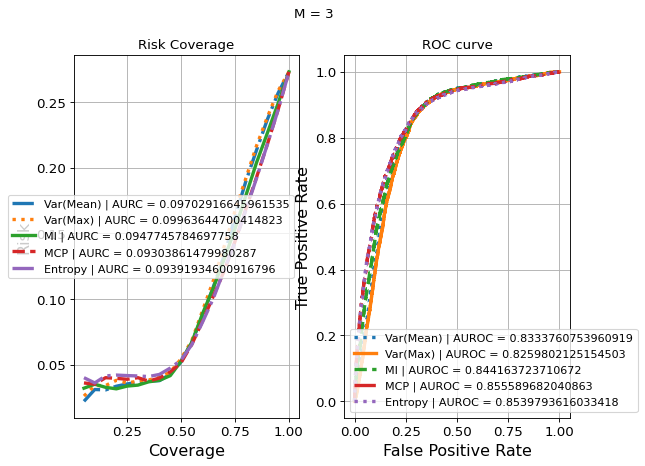

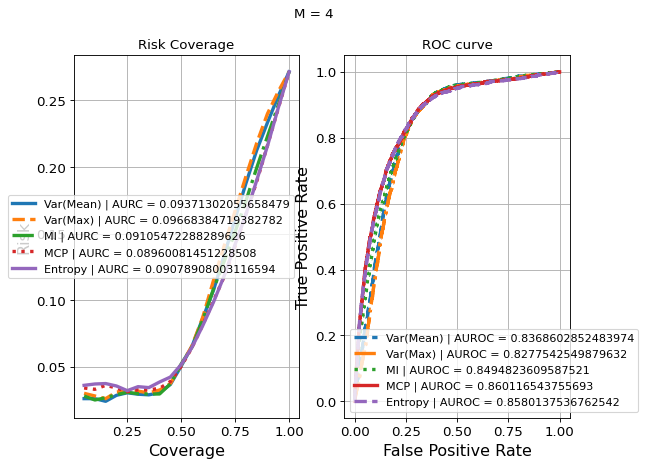

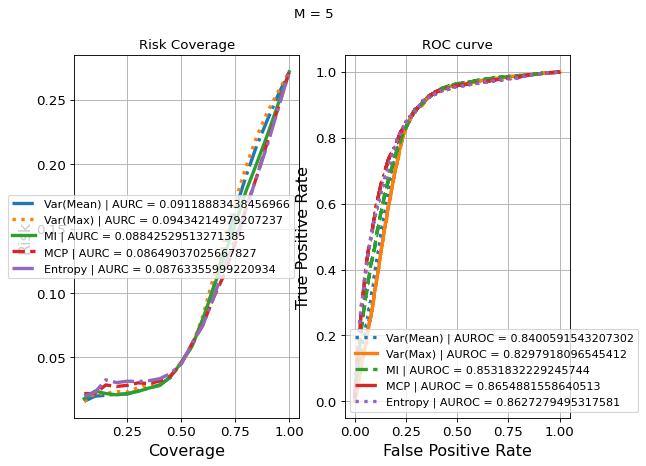

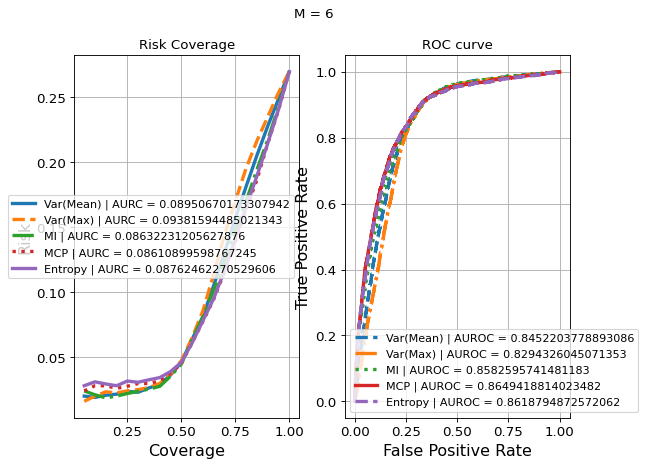

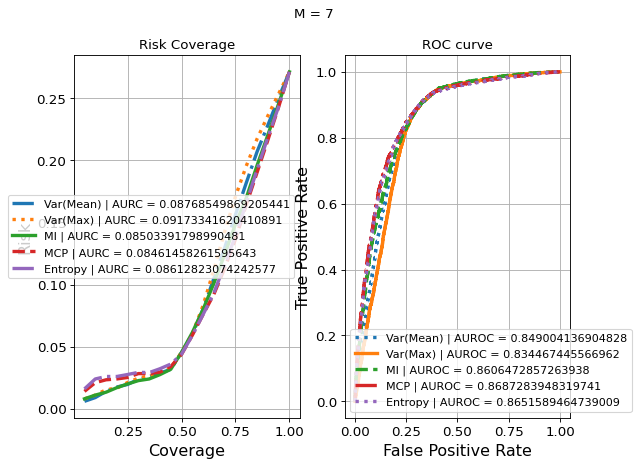

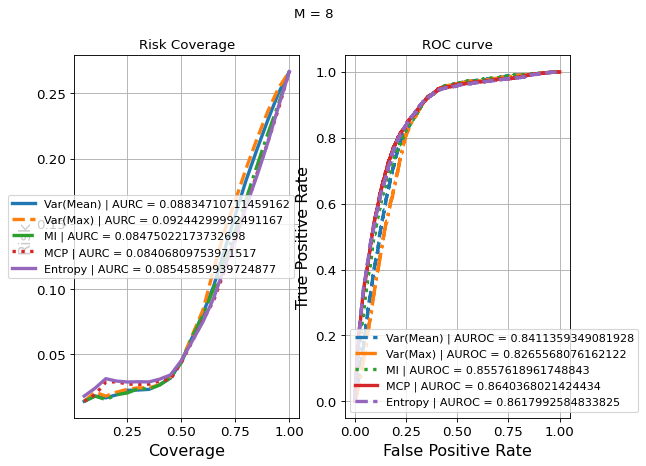

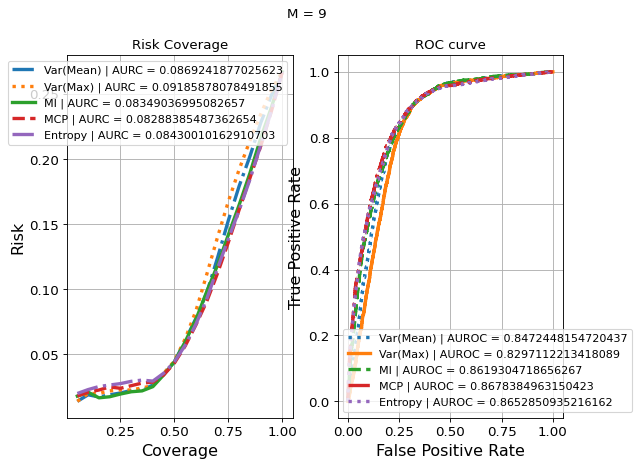

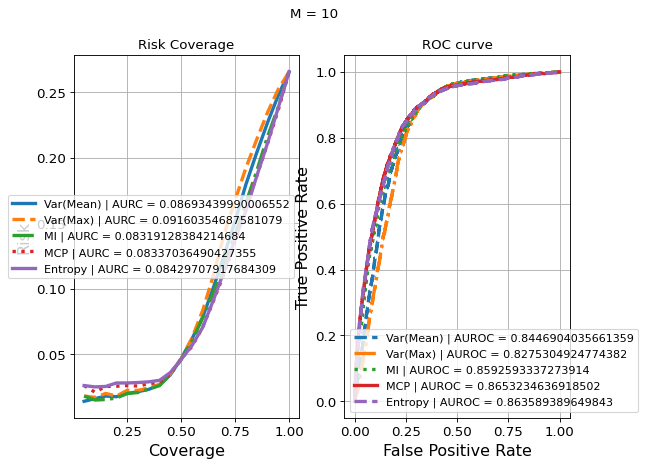

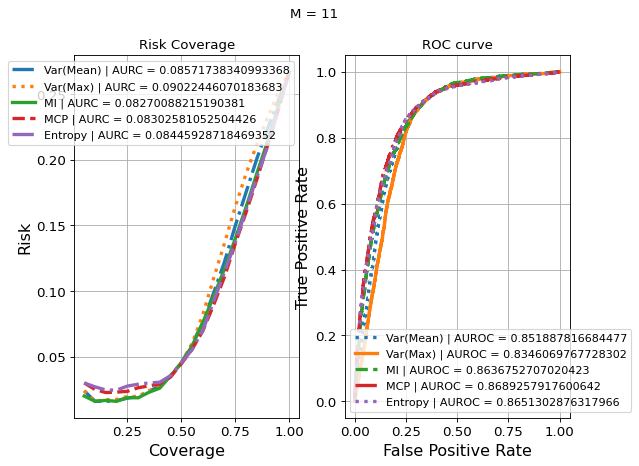

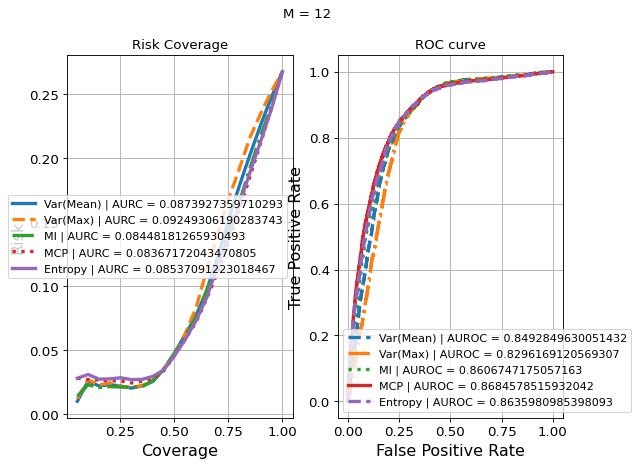

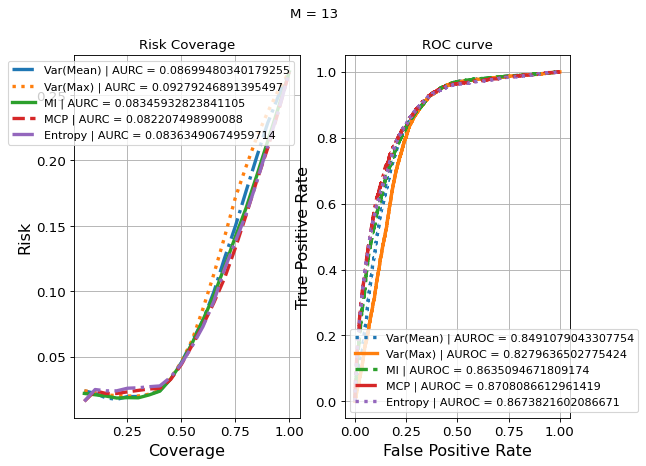

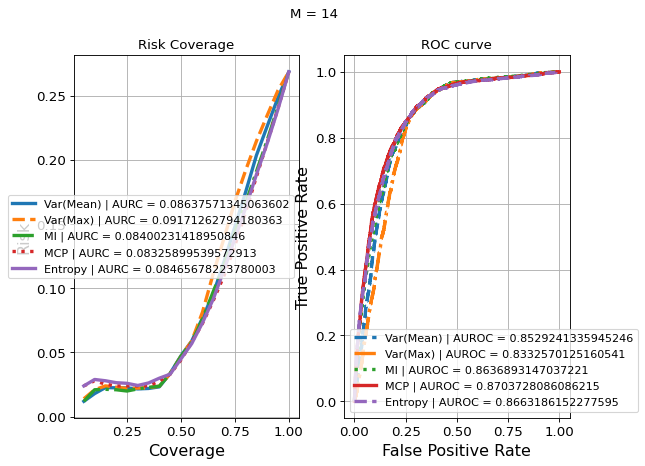

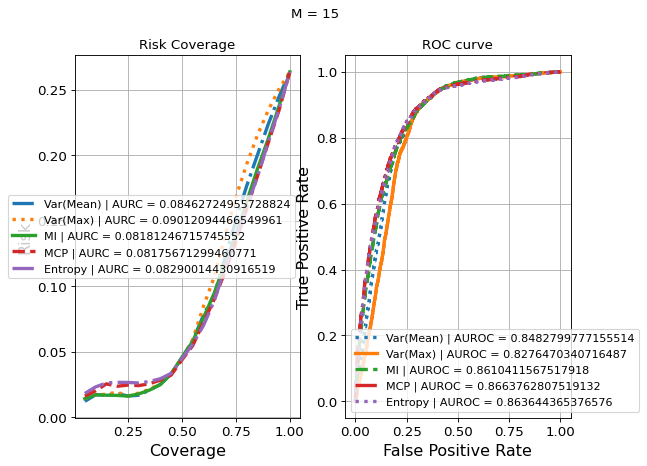

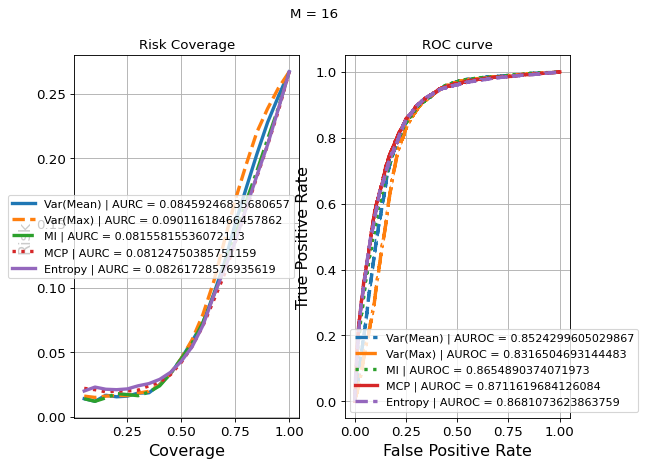

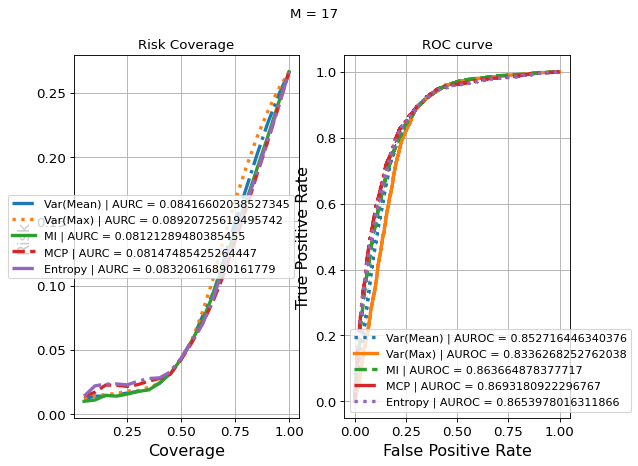

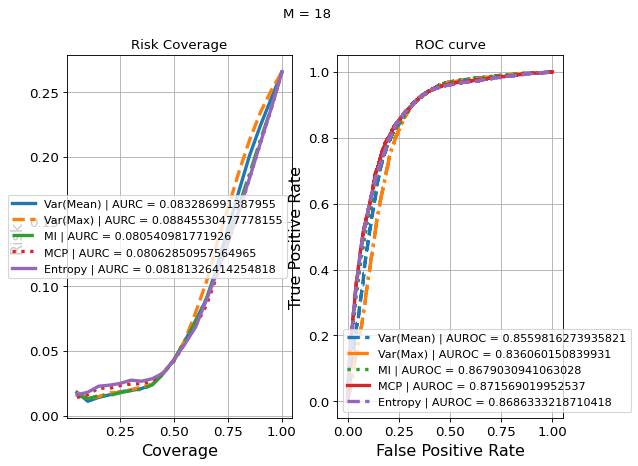

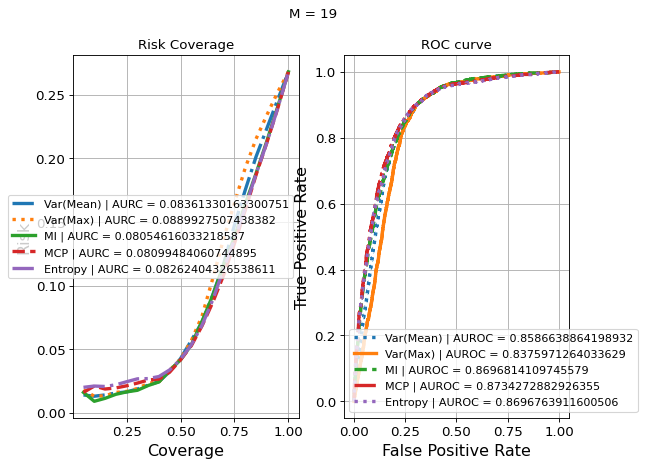

In [15]:
RC = metrics.selective_metrics(model_tta,None)
RC.get_uncs(data.test_dataloader)
RC.plot_ROC_and_RC(aurc = True)
plt.show()

### Ensemble x Deterministic Inference

#### RC

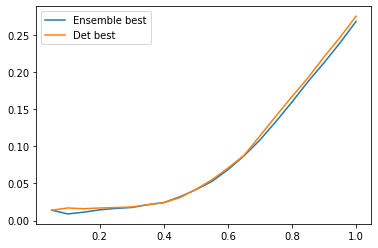

In [22]:
RC = metrics.selective_metrics(model_tta,data.test_dataloader)
RC_det = metrics.selective_metrics(model_tta_det,data.test_dataloader,labels = RC.label)
RC_det.RC_curves()
RC.RC_curves()
#RC.plot_RC(aurc = True)
plt.plot(RC.c_list,RC.get_best(),label = f'Ensemble best')
plt.plot(RC_det.c_list,RC_det.get_best(),label = f'Det best')
plt.legend()
plt.show()

In [ ]:
#det retira melhor a incerteza, porém só pq tem mais erros!